In [273]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from arch import arch_model

from prophet import Prophet

from warnings import filterwarnings
filterwarnings("ignore")

In [206]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col=['year'])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


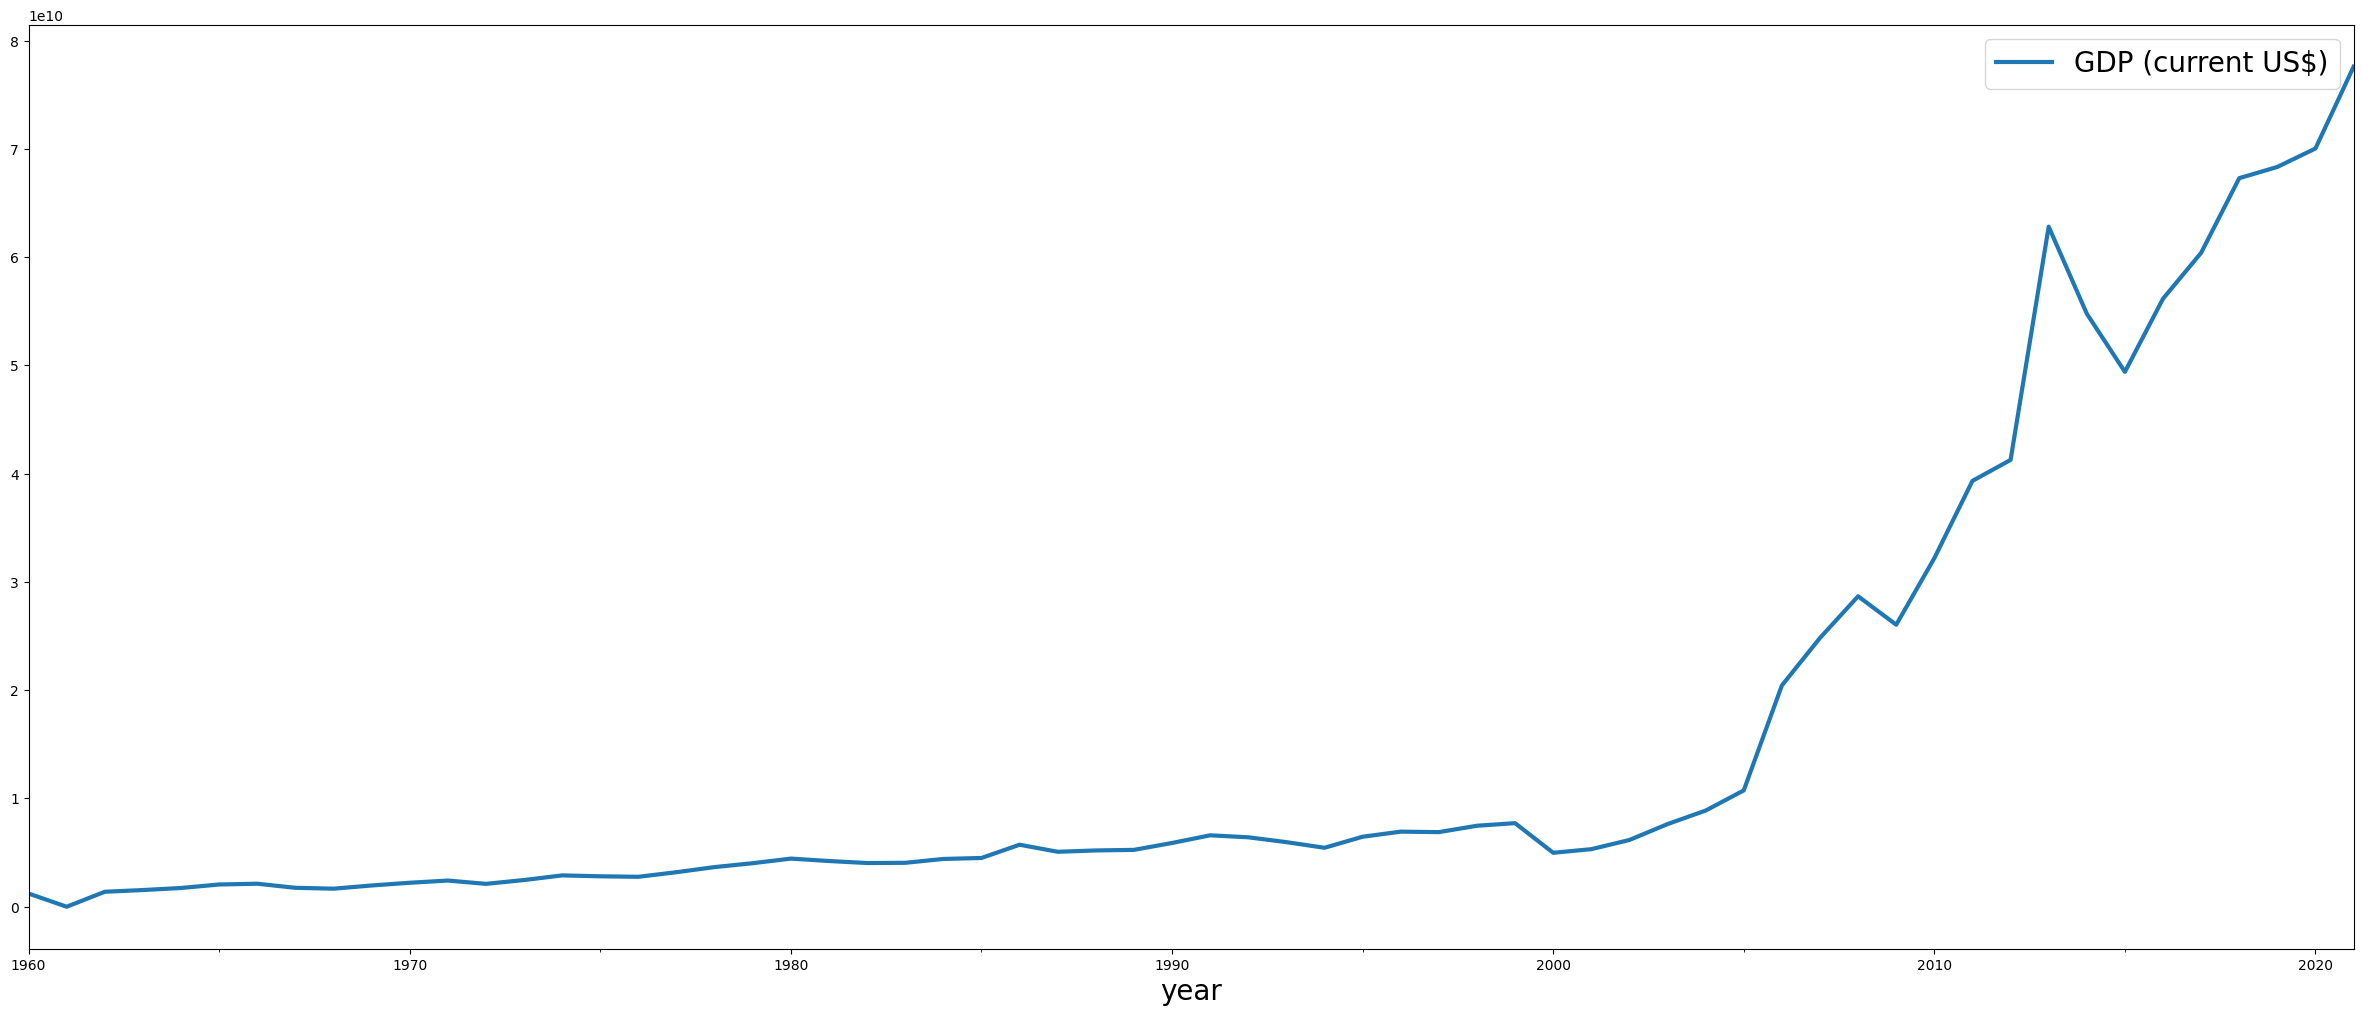

In [207]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

**Выводы**

На графике отчётливо виден восходящий тренд, при этом интенсивность роста ВВП с 2020 году резко увеличивается. Сезонность явно отсуствует.

In [208]:
train_df = data.iloc[:-3]
test_df = data.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

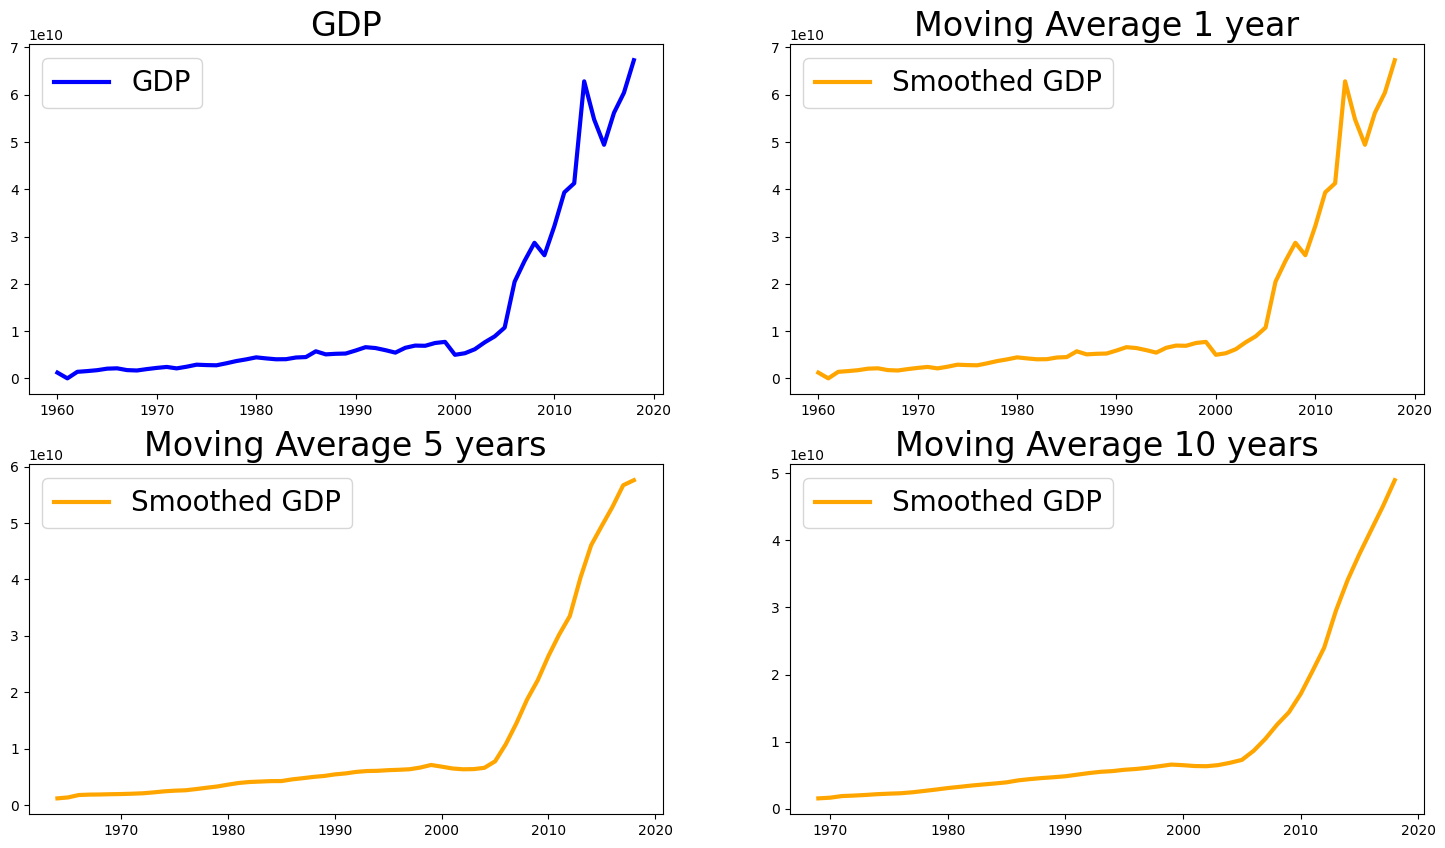

In [209]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.rolling(window=1).mean(),
    color="orange",
    label="Smoothed GDP",
)
ax[0, 1].set_title("Moving Average 1 year", size=24)
ax[0, 1].legend()


ax[1, 0].plot(train_df.rolling(window=5).mean(),
    color="orange",
    label="Smoothed GDP",
)
ax[1, 0].set_title("Moving Average 5 years", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.rolling(window=10).mean(),
    color="orange",
    label="Smoothed GDP",
)
ax[1, 1].set_title("Moving Average 10 years", size=24)
ax[1, 1].legend()

plt.show()

**Вывод**

Временной ряд фактически представляет собой тренд без сезонности и шумов

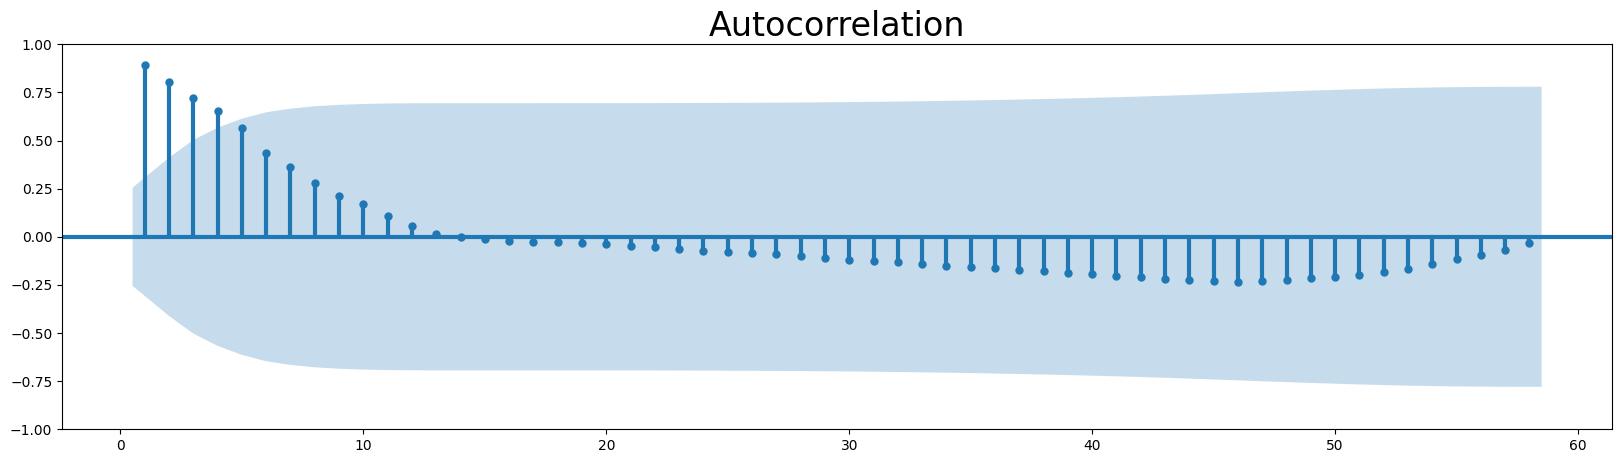

In [210]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df, lags=58, zero=False)
plt.show()

**Вывод**

Корреляция признаков показывает зависимость данных от показателей предыдущих 10 лет

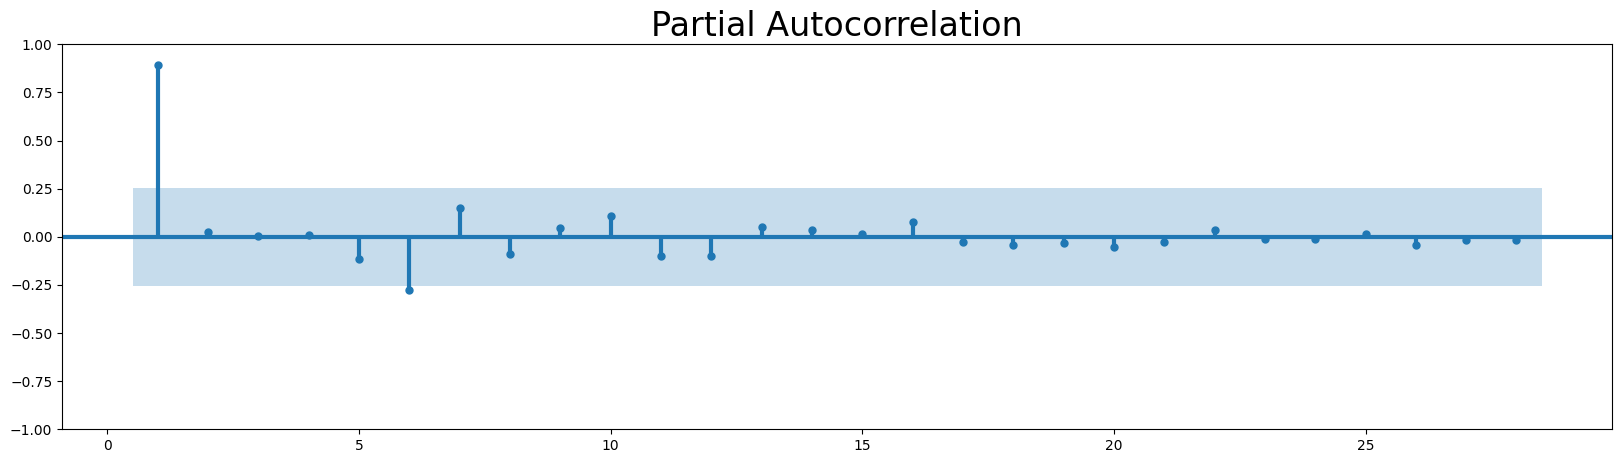

In [211]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df, lags=28, method="ywm", zero=False)
plt.show()

#### Проверка на стационарность

In [212]:
def stat_test(df):
    test = adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        return 'есть единичные корни, ряд не стационарен'
    else:
        return 'единичных корней нет, ряд стационарен'

In [213]:
print(stat_test(train_df))

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


**Вывод**

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть, то есть временной ряд не является стационарным

In [214]:
# Определяем разности
d = 0
while True:
    d += 1
    df_diff = train_df.diff(d).dropna()
    print('Производная', d)
    res = stat_test(df_diff)
    print(res)
    print()
    if res == 'единичных корней нет, ряд стационарен':
        break



Производная 1
adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен

Производная 2
adf:  -3.5836708658260297
p-value:  0.006080989753876957
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен



In [215]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1], lags=27, method="ywm")
    plt.show();

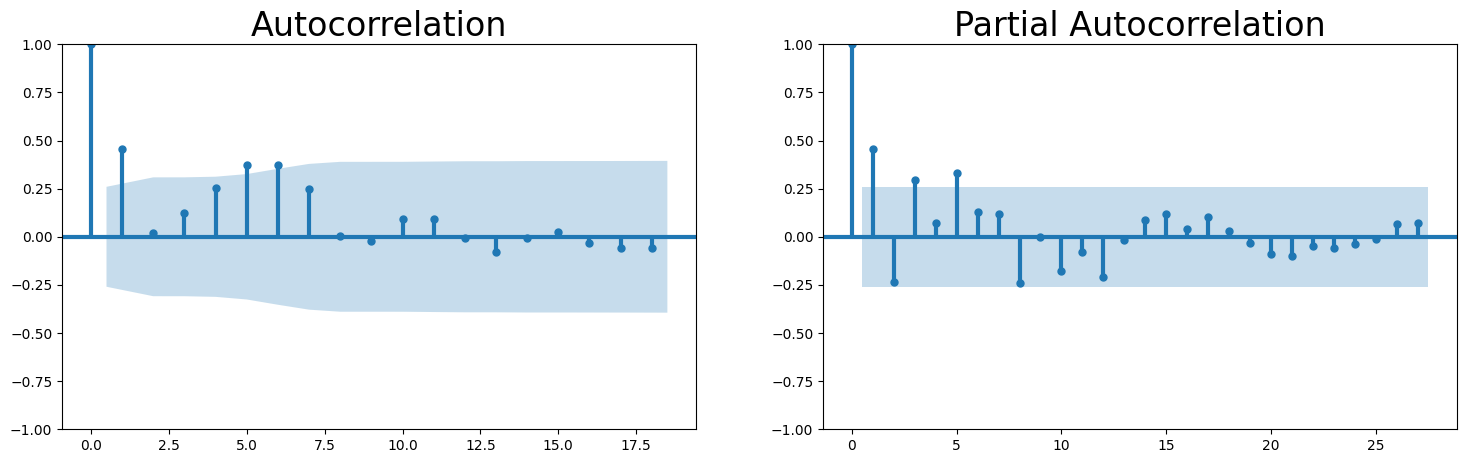

In [216]:
plot_acf_pacf(train_df.diff(d).dropna())

Вторые разности являются стационарными

## МОДЕЛЬ

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 12 
- d = 2 
- q = 10

При отсуствии сезонности и сведений об экзагенных данных применение других моделей не предполагается

In [217]:
arima_model = ARIMA(train_df.dropna(), order=(12, 2, 10))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               ARIMA(12, 2, 10)   Log Likelihood               -1333.462
Date:                Fri, 27 Oct 2023   AIC                           2712.924
Time:                        18:19:00   BIC                           2759.914
Sample:                    01-01-1960   HQIC                          2731.186
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5020    248.763     -0.002      0.998    -488.069     487.065
ar.L2          0.1132    269.123      0.000      1.000    -527.357     527.584
ar.L3          0.4728    127.313      0.004      0.997    -249.056     250.001
ar.L4          0.0088     43.627      0.000      1.000     -85.498      85.516
ar.L5          0.3540     27.560      0.013      0.990     -53.663      54.371
ar.L6          0.2441    103.865      0.002      0.998    -203.328     203.816
ar.L7          0.1940    120.777      0.002      0.999    -236.524     236.912
ar.L8         -0.6773    117.898     -0.006      0.995    -231.753     230.398
ar.L9         -0.3660     99.906     -0.004      0.997    -196.179     195.447
ar.L10         0.1278    149.061      0.001      0.999    -292.026     292.281
ar.L11         0.1623     54.427      0.003      0.998    -106.512     106.836
ar.L12        -0.0169      8.184     -0.002      0.998     -16.057      16.024
ma.L1         -0.4571    268.182     -0.002      0.999    -526.083     525.169
ma.L2         -0.8447     97.593     -0.009      0.993    -192.123     190.434
ma.L3          0.2160    212.357      0.001      0.999    -415.996     416.428
ma.L4          0.0976    216.761      0.000      1.000    -424.747     424.942
ma.L5          0.0592     65.509      0.001      0.999    -128.335     128.454
ma.L6          0.2758    136.104      0.002      0.998    -266.483     267.034
ma.L7          0.6908    132.236      0.005      0.996    -258.487     259.868
ma.L8         -0.9653    217.623     -0.004      0.996    -427.498     425.567
ma.L9         -0.5021    124.318     -0.004      0.997    -244.162     243.158
ma.L10         0.4448    192.061      0.002      0.998    -375.988     376.878
sigma2      2.114e+18   2.71e-16   7.79e+33      0.000    2.11e+18    2.11e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                68.52
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              48.22   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.6e+52. Standard errors may be unstable.
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [218]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df['GDP'] = data['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [219]:
pred_df

,model_preds,GDP,model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.313271e+10,6.833754e+10,6.011559e+10,6.614983e+10


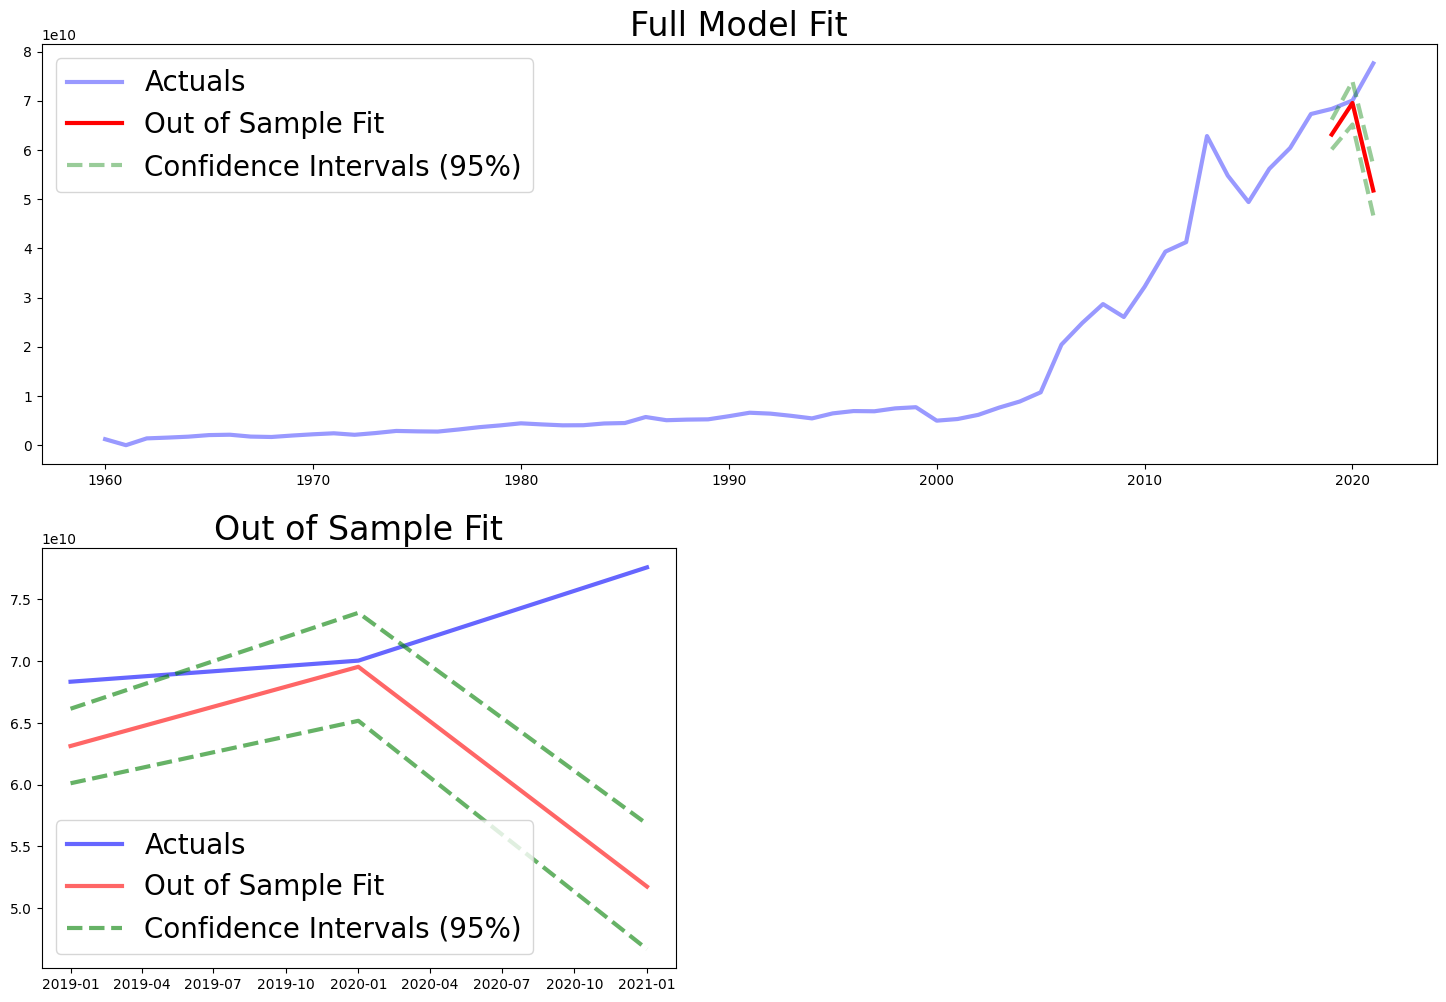

In [220]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show();

In [221]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=12,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.667, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.622, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.414, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.988, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.765, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2686.992, Time=0.04 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.648, Time=0.12 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.800, Time=0.09 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2688.234, Time=0.10 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.409, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.657, Time=0.13 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 27 Oct 2023   AIC                           2680.765
Time:                        18:19:01   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [222]:
arima_best = ARIMA(train_df.dropna(), order=(1, 2, 3))
arima_best_fit = arima_best.fit()
arima_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 27 Oct 2023   AIC                           2680.765
Time:                        18:19:02   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [223]:
spred_df = pd.DataFrame(index=data.index)

spred_df["model_spreds"] = arima_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


spred_df['GDP'] = data['GDP (current US$)']

forecast = arima_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

spred_df.at[test_df.index, "model_spreds_lower"] = forecast_df["lower GDP (current US$)"]
spred_df.at[test_df.index, "model_spreds_upper"] = forecast_df["upper GDP (current US$)"]

In [224]:
spred_df

,model_spreds,GDP,model_spreds_lower,model_spreds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,6.789080e+10,6.833754e+10,5.941329e+10,7.636831e+10


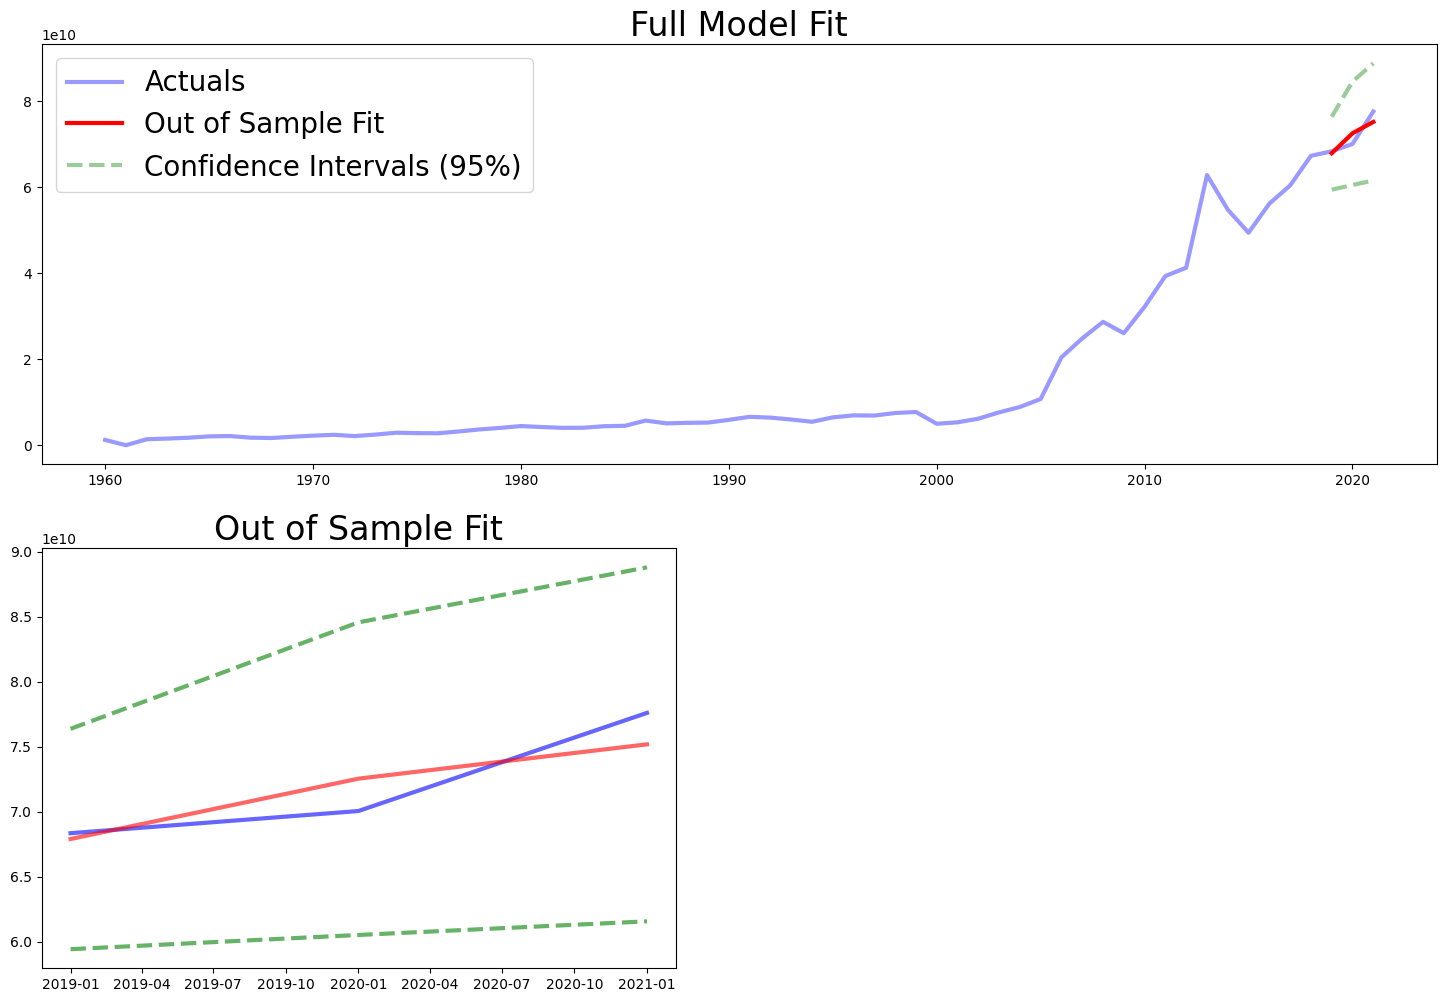

In [225]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(spred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    spred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
# plt.legend()

plt.show();

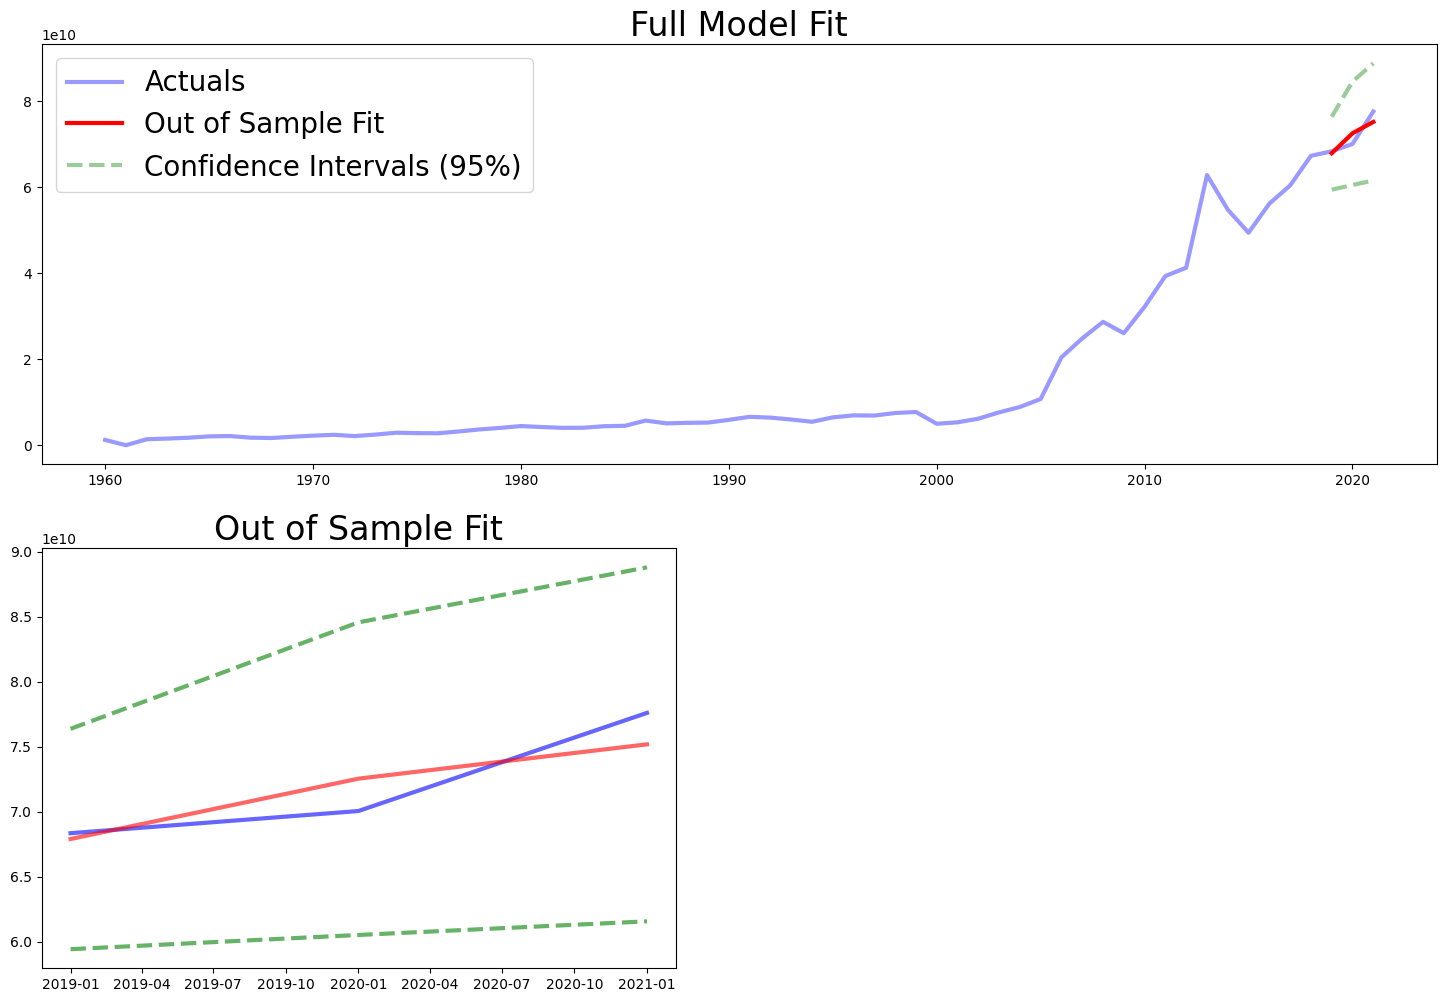

In [226]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(spred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    spred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
# plt.legend()

plt.show();

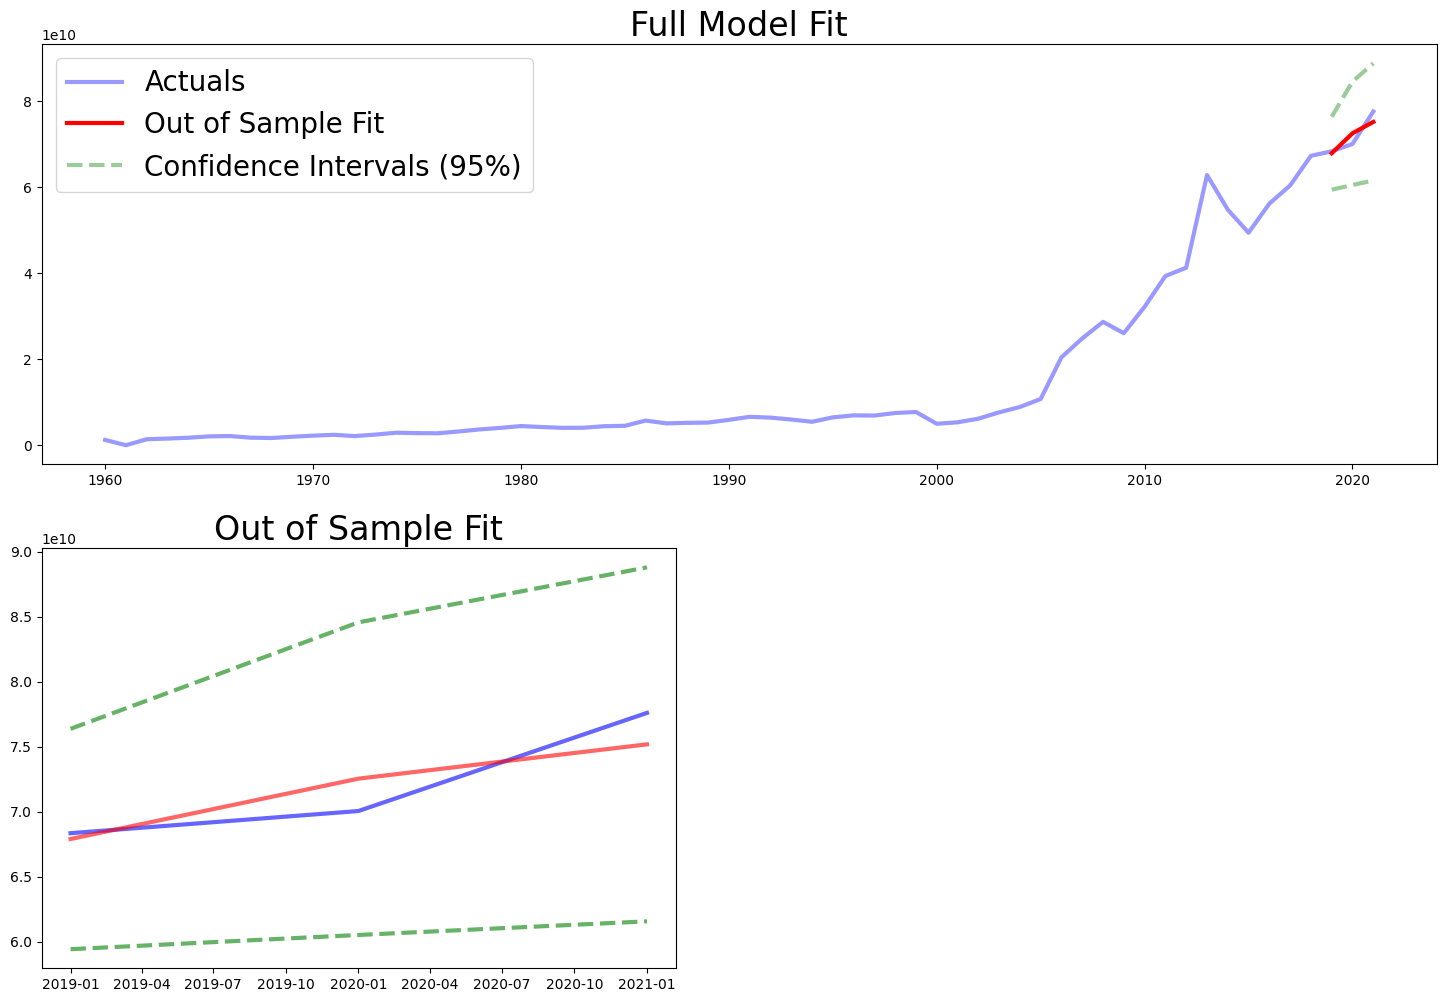

In [227]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(spred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    spred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
# plt.legend()

plt.show();

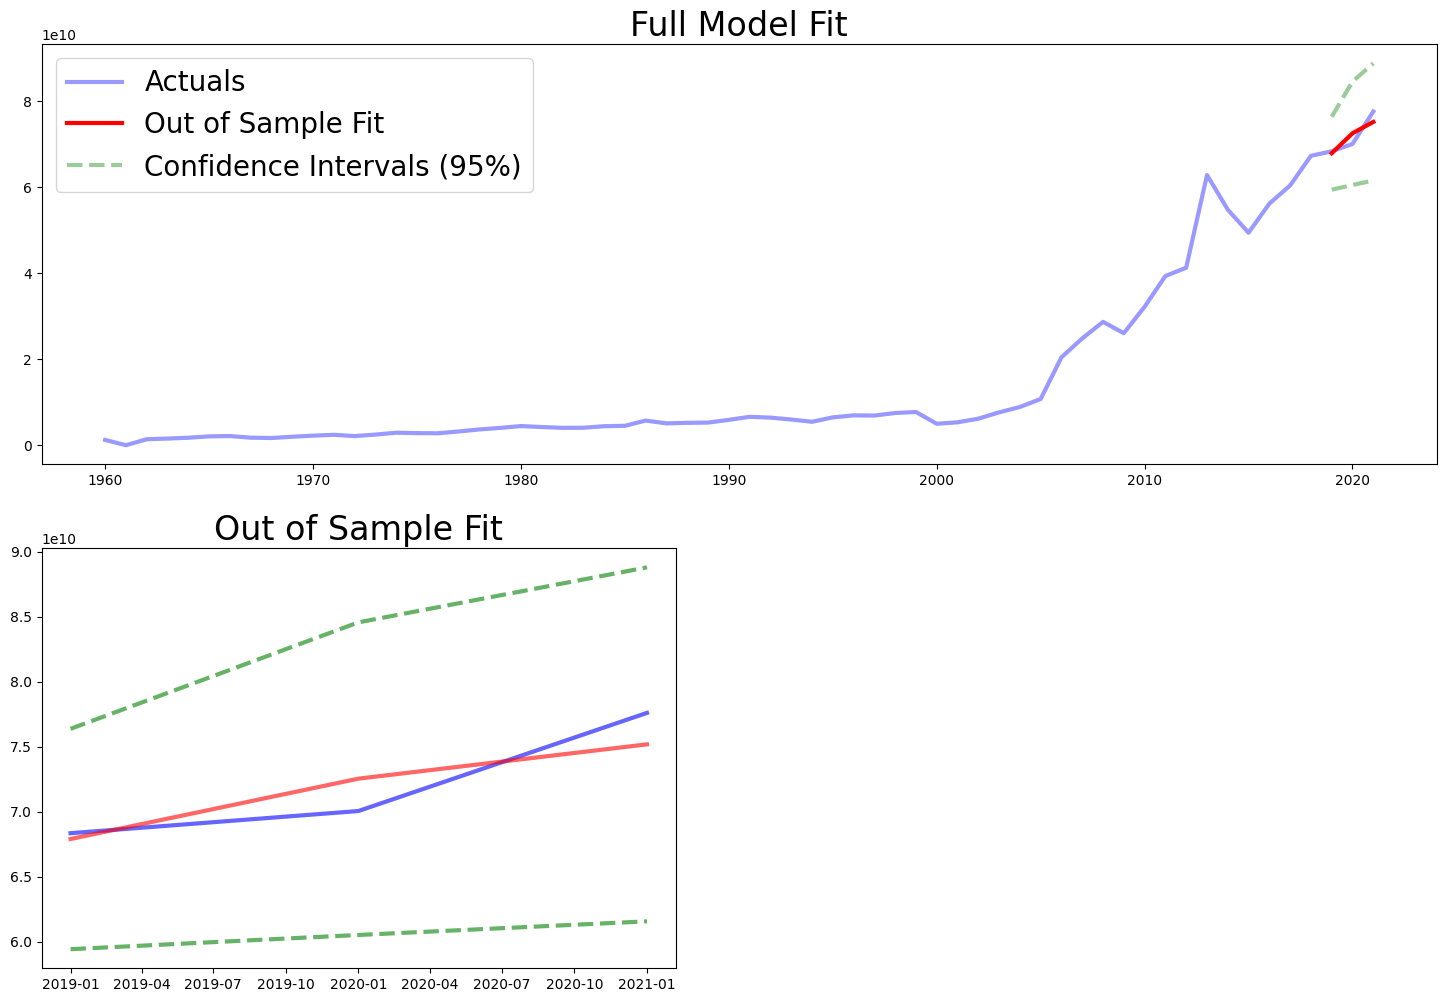

In [228]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(spred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    spred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    spred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
# plt.legend()

plt.show();

### Проверка на пропуски

In [229]:
# Пропущенные даты
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [230]:
# Поиск пропущенных значений
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data.isna().sum()

GDP (current US$)    1
dtype: int64

### Интерполяция

In [231]:
data_i = pd.DataFrame(data['GDP (current US$)'].interpolate(method='linear'))

In [232]:
train_df = data_i.iloc[:-3]
test_df = data_i.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [233]:
print(stat_test(train_df))

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
есть единичные корни, ряд не стационарен


In [234]:
d = 0
while True:
    d += 1
    df_diff = train_df.diff(d).dropna()
    print('Производная', d)
    res = stat_test(df_diff)
    print(res)
    print()
    if res == 'единичных корней нет, ряд стационарен':
        break

Производная 1
adf:  -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
есть единичные корни, ряд не стационарен

Производная 2
adf:  -3.999803440949147
p-value:  0.0014115408436661371
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
единичных корней нет, ряд стационарен



In [235]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=12,
    max_q=10,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2704.584, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2683.547, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2681.389, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2680.921, Time=0.08 sec


 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=2680.513, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=2687.184, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=2682.393, Time=0.11 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=2682.617, Time=0.11 sec
 ARIMA(0,2,4)(0,0,0)[0]             : AIC=2687.812, Time=0.09 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=2683.040, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2686.809, Time=0.20 sec

Best model:  ARIMA(1,2,3)(0,0,0)[0]          
Total fit time: 1.144 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 27 Oct 2023   AIC                           2680.513
Time:                        18:19:05   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [236]:
arima_best = ARIMA(train_df.dropna(), order=(1, 2, 3))
arima_best_fit = arima_best.fit()
arima_best_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 27 Oct 2023   AIC                           2680.513
Time:                        18:19:05   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [237]:
ipred_df = pd.DataFrame(index=data.index)

ipred_df["model_spreds"] = arima_best_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


ipred_df['GDP'] = data['GDP (current US$)']

forecast = arima_best_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)

ipred_df.at[test_df.index, "model_spreds_lower"] = forecast_df["lower GDP (current US$)"]
ipred_df.at[test_df.index, "model_spreds_upper"] = forecast_df["upper GDP (current US$)"]

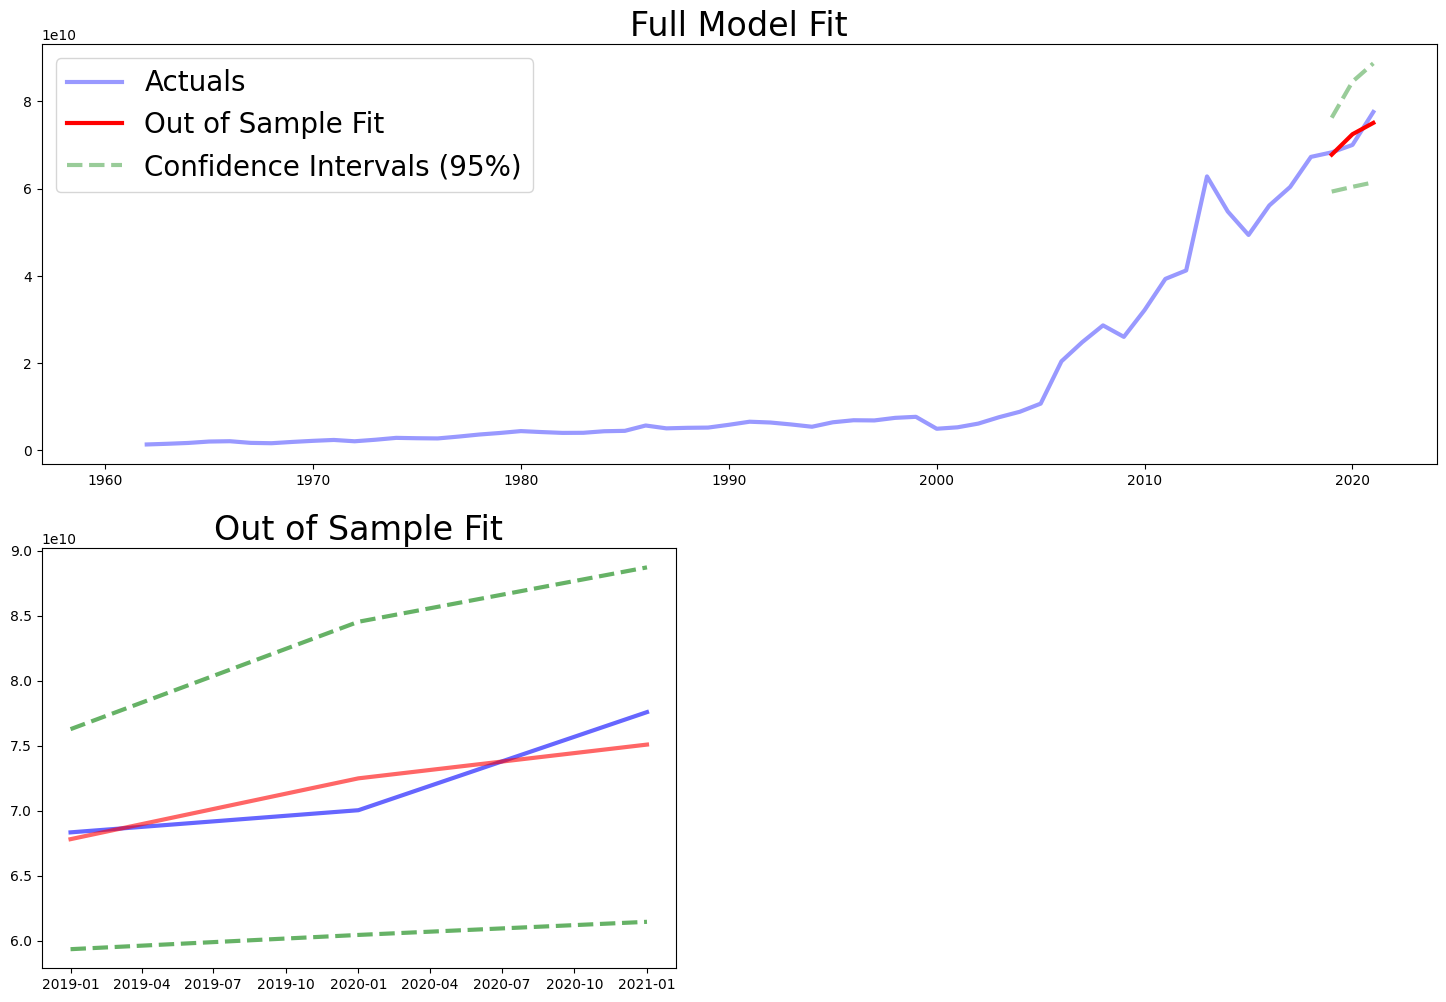

In [238]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(ipred_df["GDP"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    ipred_df.loc[test_df.index]["GDP"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    ipred_df.loc[test_df.index]["model_spreds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
# plt.legend()

plt.show();

**Вывод**

Интерполяция одного значения не повлияло на предсказание и критерий Акакике


### Валидация временных рядов

**Задание 8.3**

In [239]:
# 1. Разбейте временной ряд на три набора

tscv = TimeSeriesSplit(n_splits=3, test_size=7)

fold_group = tscv.split(data_i)

In [240]:
for train_index, test_index in fold_group:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


## Волатильность

In [241]:
data_i

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [242]:
# data["gdp_vol"] = (data.gdp - data.gdp.shift(1))/data.gdp.shift(1)
data_i["gdp_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data_i["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

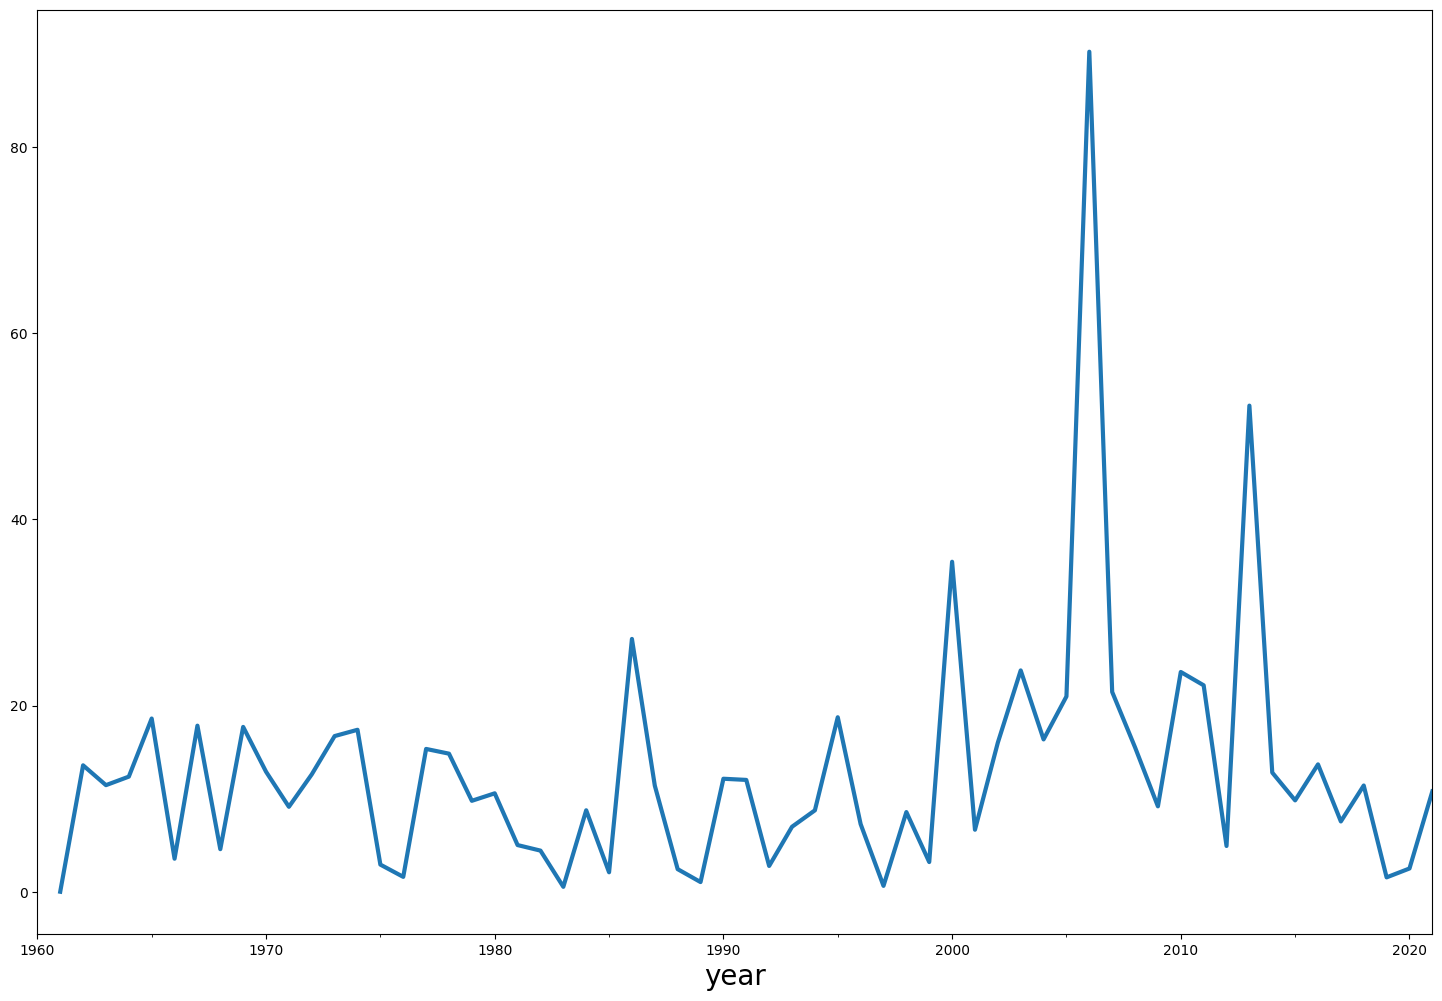

In [243]:
data_i["gdp_vol"].plot()
plt.show()

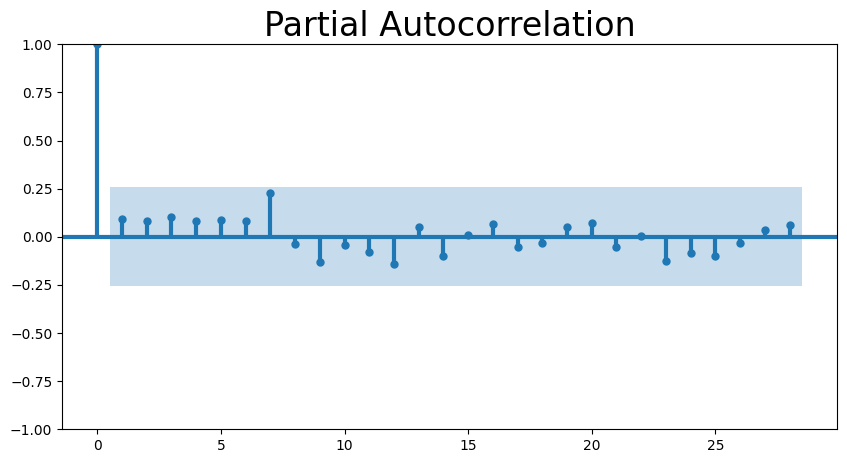

In [244]:
train_df = data_i.iloc[:-3]
test_df = data_i.iloc[-3:]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.gdp_vol[1:], lags=28, method="ywm")
plt.show()

In [245]:
print(stat_test(train_df.gdp_vol[1:]))

adf:  -6.816105099260228
p-value:  2.0572875762632108e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
единичных корней нет, ряд стационарен


In [267]:
garch_df = pd.DataFrame(data_i["gdp_vol"].loc[data.index]).dropna()

# в параметре last_obs указываем последний объект, до которого будем совершать обучение - до первого объекта из test выборки
model_arch = arch_model(garch_df, p=2, q=2, vol="GARCH").fit(last_obs=test_df.index[0], update_freq=5)
model_arch.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 229.3859465639944
Iteration:     10,   Func. Count:     75,   Neg. LLF: 227.7029573981161
Iteration:     15,   Func. Count:    110,   Neg. LLF: 227.56407851901568
Iteration:     20,   Func. Count:    145,   Neg. LLF: 227.48396484447403
Optimization terminated successfully    (Exit mode 0)
            Current function value: 227.48361196906473
            Iterations: 23
            Function evaluations: 158
            Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -227.484
Distribution:                  Normal   AIC:                           466.967
Method:            Maximum Likelihood   BIC:                           479.330
                                        No. Observations:                   58
Date:                Fri, Oct 27 2023   Df Residuals:                       57
Time:                        18:39:27   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3709      2.077      5.956  2.591e-09 [  8.300, 16.442]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.5723     16.472      0.217      0.828 [-28.713, 35.857]
alpha[1]       0.0000      0.106      0.000      1.000 [ -0.208,  0.208]
alpha[2]       0.0000      0.148      0.000      1.000 [ -0.290,  0.290]
beta[1]        1.0000      0.902      1.109      0.268 [ -0.768,  2.768]
beta[2]    8.3894e-11      0.865  9.700e-11      1.000 [ -1.695,  1.695]
========================================================================

Covariance estimator: robust
"""

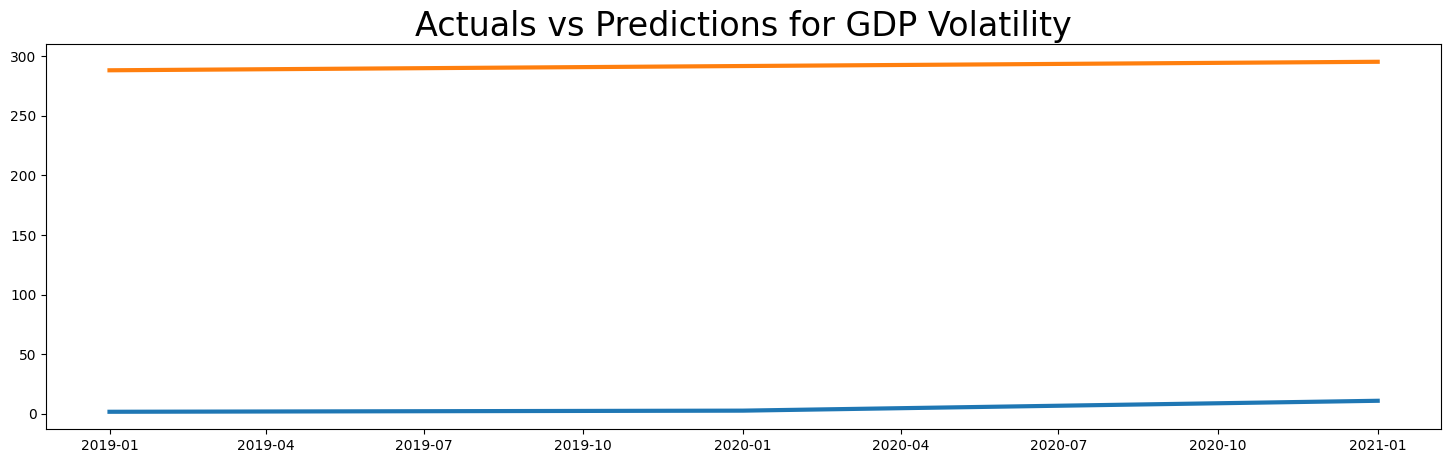

In [268]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_arch.forecast().residual_variance.loc[test_df.index]

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show();

In [269]:
mean_squared_error(predictions_df["gdp_vol"].abs(), predictions_df["Predictions"])

82349.60447240587

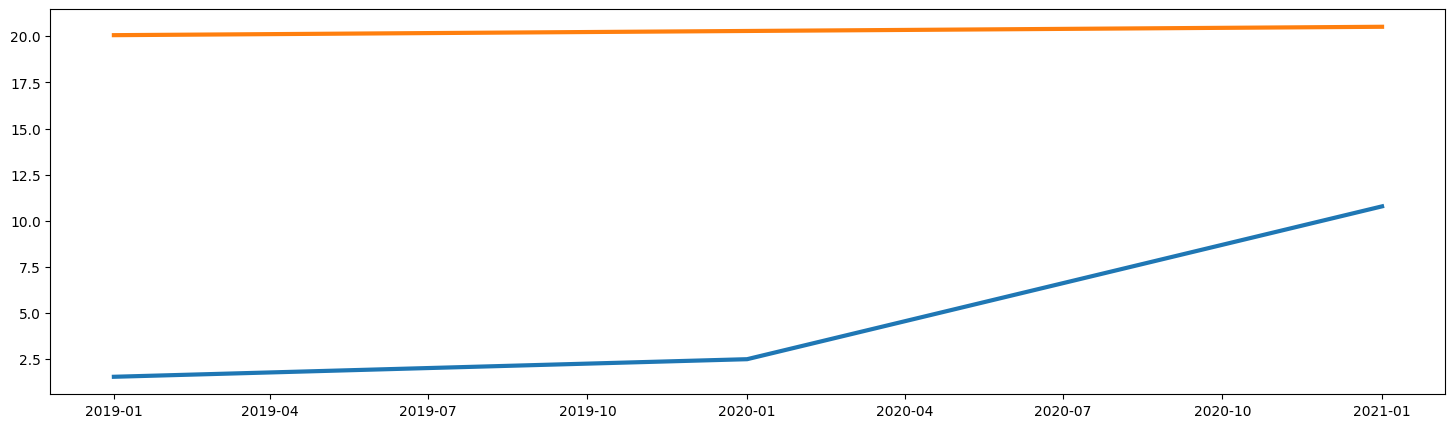

In [271]:
X_train = pd.DataFrame(range(data_i["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data_i["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

## ПРОРОК

In [276]:
url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(url)
df.tail()

,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [278]:
model = Prophet()
model.fit(df)

19:10:15 - cmdstanpy - INFO - Chain [1] start processing
19:10:16 - cmdstanpy - INFO - Chain [1] done processing


In [279]:
# Получаем даты, для которых должен быть сделан прогноз (periods - количество дней)

future_df = model.make_future_dataframe(periods=365)
future_df.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [280]:
# Прогнозируем. Результат - значение (YHAT) и доверительного интервал ('yhat_lower', 'yhat_upper')
forecast_df = model.predict(future_df)
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206964,7.472053,8.892979
3266,2017-01-16,8.531958,7.811181,9.235099
3267,2017-01-17,8.319376,7.571056,9.033760
3268,2017-01-18,8.151991,7.452718,8.909891
3269,2017-01-19,8.163908,7.457944,8.917241


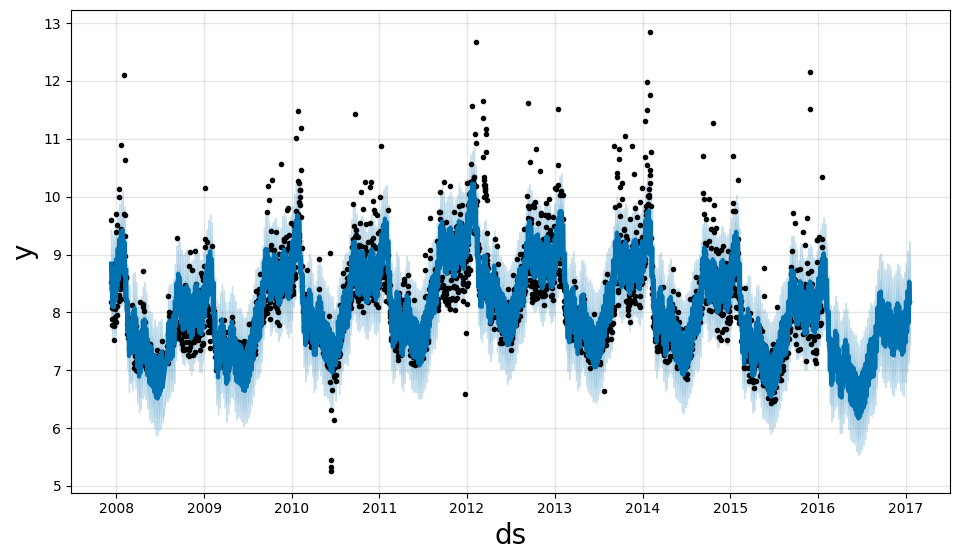

In [281]:
# Визуализируем прогноз
fig = model.plot(forecast_df)

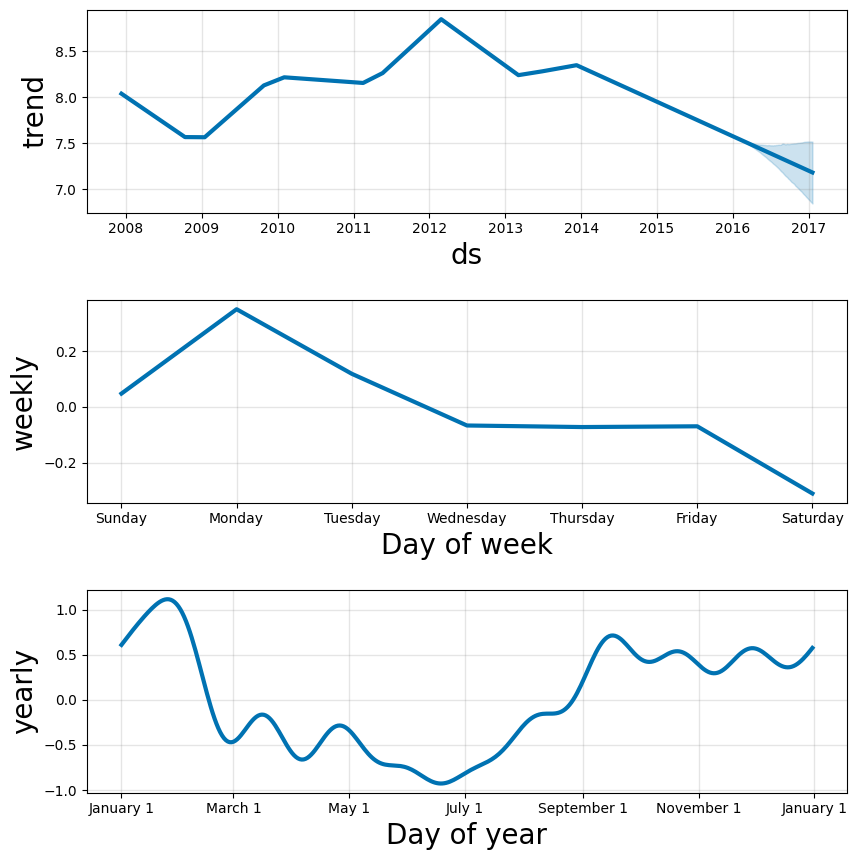

In [282]:
# Визуализируем компаненты ряда
fig = model.plot_components(forecast_df)